(chap-exploring_a_database)=
# Exploring a database with `csv`


```{important}
Usually, directories of experimental records are produced by colleagues in the lab. It is essential that there is ongoing discussion between the experimentalists and the people who will later analyze the data, such as data scientists. If data scientists modify the structure of the records directory, it becomes much harder to maintain this communication and can significantly slow down the process of data exploitation and analysis. Therefore, following good practices for organizing and managing the data is crucial.
```

See Section "{ref}`chap-csv`" for an introduction to `csv` in the context with `panda` and `csvkit`.

## Building a `csv`file

We consider a dataset in `data/records_fake`.  

This dataset consists of a set of (empty) records compiled in 2024, from March 15 to June 26, by [Joanna Danielewicz](https://www.linkedin.com/in/joanna-danielewicz-522139b6/?originalSubdomain=es) at the [Mathematical, Computational and Experimental](https://www.bcamath.org/en/research/areas/m3a/mcen) lab, headed by [Serafim Rodrigues](https://www.ikerbasque.net/es/serafim-rodrigues) at [BCAM](https://www.bcamath.org/en).  

The directory structure is the same as in the real dataset, but the files are empty, since the original recordings are too large. Later, we will work with selected real recordings.

In the `data` directory I have a subdirectory `records_fake` that contains empty `abf` and `atf` files, the structure is:

In [13]:
!tree -L 2 data/data_bcam_2024/records

data/data_bcam_2024/records
├── 03.15
│   ├── C1
│   └── C2
├── 03.20
│   └── C1
├── 04.10
│   ├── C1
│   ├── C2 immature
│   └── C3
├── 05.07
│   ├── C1 DG
│   └── C2 DG
├── 05.20
│   ├── C1
│   ├── C2
│   ├── C3
│   ├── C4
│   └── C5
├── 05.23
│   ├── C1
│   ├── C2
│   ├── C3
│   └── C4
├── 05.29
│   ├── C1
│   ├── C2
│   └── C3 immature
├── 05.30
│   ├── C1
│   └── C2
├── 06.19
│   ├── C1
│   └── C2
├── 06.26
│   ├── C1
│   ├── C2
│   └── C3
└── README.md

37 directories, 1 file


First we  present somes good practices about records directory.

## Good practrices about records directory


### Directory structure: flatten or not?

- Keep the hierarchy (date → cell → files).
- It mirrors the experimental workflow (date of recording, then cell).
- Easier to reason about provenance ("what did we do on May 30?").
- Helps you separate sessions and avoid accidental filename collisions.
- Flattening could be useful for scripts, but you can always create virtual flattening in Python (e.g., by walking the directory tree). So I’d keep the hierarchy and let code do the flattening.

**Recommendation:** Keep the directory hierarchy. Use scripts to index/flatten when needed.

### Metadata handling

- Do not rely only on filenames — they’re fragile and inconsistent.
- Best practice: keep a `metadata` table (CSV, TSV, JSON, YAML, or SQLite DB), eg. a `metadata.csv` to store all experiment details.  
  - You can add or correct metadata later without touching raw files.  
  - Easy to query and filter in Python (e.g., with `pandas`).  
  - Prevents the need to rename files whenever metadata changes.  

**Recommendation:** Maintain a single central metadata file (CSV for simplicity, or SQLite if the dataset grows large).  

### `README.md`

Add a `README.md` in the data file that includes:
- Directory structure
- Naming conventions
- Protocol/temperature shorthand
- Instructions for using metadata

### File Naming

- Keep original filenames from acquisition (ground truth).
- Do not overwrite raw files.
- If you want clean names, create symbolic links or derived copies like: `cellID_date_protocol.abf`, eg. you can make a (flat) dir of symbolic links:
```
symlinks/
├── C21_05.30.abf
├── C22_05.30.abf
├── C23_06.19.abf
```

### Keep raw data read-only

- Protects raw data integrity → accidental edits, renames, or deletions won’t happen.
- Clear separation between:
   - Raw data (immutable, read-only)
   - Derived data / analysis results (reproducible, regeneratable)
- Works well with the principle: “never touch your raw data, always derive.”
- In multi-user setups (lab server, shared cluster), permissions protect against colleagues accidentally overwriting.

**Things to keep in mind**
- You may still want to add new files (new experiments) → so you don’t want to lock the whole records root permanently. Instead, set read-only permissions per experiment once it’s finalized.
- If you ever need to move or reorganize, you’ll have to re-enable write permissions (chmod u+w).
- A safer alternative:
   - Keep raw records as read-only
   - Mirror it to a version-controlled metadata database (metadata.csv or SQLite), which you can edit freely




## Back to the case study

To make everything in 'data/records_fake/' read-only:

In [14]:
!chmod -R a-w data/data_bcam_2024/records
!ls -l data/data_bcam_2024/records/*/*/* | head -n 5

-r--r--r--  1 campillo  staff  0 29 sep 14:59 data/data_bcam_2024/records/03.15/C1/2024_03_15_0000 IC steps 23.abf
-r--r--r--  1 campillo  staff  0 29 sep 14:59 data/data_bcam_2024/records/03.15/C1/2024_03_15_0001 IC ramp 23.abf
-r--r--r--  1 campillo  staff  0 29 sep 14:59 data/data_bcam_2024/records/03.15/C1/2024_03_15_0002 IC sin 23.abf
-r--r--r--  1 campillo  staff  0 29 sep 14:59 data/data_bcam_2024/records/03.15/C1/2024_03_15_0003 VC ramp 23.abf
-r--r--r--  1 campillo  staff  0 29 sep 14:59 data/data_bcam_2024/records/03.15/C1/2024_03_15_0004 IC ramp 25.abf


Now everybody (owner, group, all) car read the files but cannot write (or execute), files can still be read and copied. Still under MacOS with `Finder` you can make some damages, you can make them immutable:

In [15]:
!chflags -R uchg data/data_bcam_2024/records

Note the little lockers in Finder:

![chflags](pics/chflags.png)

(To undo: `chflags -R nouchg records`)



```{tip}
Best practices
- Keep raw data untouched.
- Keep raw data read-only once experiments are finalized.
- Track metadata in metadata.csv — symlinks are just for easier file access, not metadata storage.
- If necessary, use symlinks for convenience (clean naming, flat access).
```

## Pandas DataFrame

**pandas DataFrame** (df) is far better than built-in Python tools like lists, dictionaries, or arrays for the following reasons:

- Tabular structure built-in
   - A DataFrame behaves like a table or spreadsheet: rows = records, columns = fields.
   - You don’t have to manually manage parallel lists or nested dictionaries.
- Easy indexing and filtering: doing the same with lists/dicts would require loops and conditionals — much more verbose
- Powerful aggregation & grouping: compute counts, averages, sums, or custom statistics without writing loops
- Built-in handling of missing data
   - Pandas understands `NaN` values automatically.
   - Built-in functions handle missing data gracefully.
- Integration with plotting and analysis
- Easy I/O; Load/save CSV, Excel, SQL, JSON, and more with a single command.

See infra.


```{index} single: Panda ; DataFrame
```

## Back to the case study: the boring job !

**This part is as necessary as it is boring !** 
From directory `data/data_bcam_2024/records` (which we will not modify), we generate a metadata file `ddata/data_bcam_2024/records_metadata.csv` in CSV format. The procedure is somewhat tricky and was developed **step by step** with the help of ChatGPT.

The final python script (not very informative) is `data/data_bcam_2024/create_metadata.py`. 



In [33]:
!cd data/data_bcam_2024 && python3 create_metadata.py
metadata_file = "data/data_bcam_2024/records_metadata_clean.csv"

Step 1: columns cell_id, file_path, file_name
Step 2: column date
Step 3: column exp_nb
Step 4: column comments
Step 5: column protocol
Step 6: column prot-opt
Step 7: column tp
Step 8: refine comments
Step 9: separate bad records
Final CSV saved to :
   records_metadata.csv        that contains references to all records
   records_metadata_clean.csv  that contains references to all clean records
   records_metadata_bad.csv    that contains references to all bad records
   records_metadata.csv =  records_metadata_clean.csv + records_metadata_bad.csv


In [35]:

import pandas as pd              
df = pd.read_csv(metadata_file) # load the metadata
df.head(1000)                   # display the first few rows

exp_nb cell_id        date protocol prot-opt    tp comments  \
0         1      C1  2024-03-15       IC    steps  23.0      NaN   
1         2      C1  2024-03-15       IC     ramp  23.0      NaN   
2         3      C1  2024-03-15       IC      sin  23.0      NaN   
3         4      C1  2024-03-15       VC     ramp  23.0      NaN   
4         5      C1  2024-03-15       IC     ramp  25.0      NaN   
..      ...     ...         ...      ...      ...   ...      ...   
639     655     C27  2024-06-26       IC     ramp  34.0      NaN   
640     656     C27  2024-06-26       IC      sin  34.0      NaN   
641     657     C27  2024-06-26       VC     ramp  34.0      NaN   
642     658     C27  2024-06-26       IC     ramp  37.0      NaN   
643     659     C27  2024-06-26       VC     ramp  37.0      NaN   

                                    file_path                        file_name  
0    03.15/C1/2024_03_15_0000 IC steps 23.abf  2024_03_15_0000 IC steps 23.abf  
1     03.15/C1/2024_03_15_0001 IC ramp 23.abf   2024_03_15_0001 IC ramp 23.abf  
2      03.15/C1/2024_03_15_0002 IC sin 23.abf    2024_03_15_0002 IC sin 23.abf  
3     03.15/C1/2024_03_15_0003 VC ramp 23.abf   2024_03_15_0003 VC ramp 23.abf  
4     03.15/C1/2024_03_15_0004 IC ramp 25.abf   2024_03_15_0004 IC ramp 25.abf  
..                                        ...                              ...  
639   06.26/C3/2024_06_26_0044 IC ramp 34.abf   2024_06_26_0044 IC ramp 34.abf  
640    06.26/C3/2024_06_26_0045 IC sin 34.abf    2024_06_26_0045 IC sin 34.abf  
641   06.26/C3/2024_06_26_0046 VC ramp 34.abf   2024_06_26_0046 VC ramp 34.abf  
642   06.26/C3/2024_06_26_0047 IC ramp 37.abf   2024_06_26_0047 IC ramp 37.abf  
643   06.26/C3/2024_06_26_0048 VC ramp 37.abf   2024_06_26_0048 VC ramp 37.abf  

[644 rows x 9 columns]

We end up with:

- a complete consolidated CSV (`records_metadata.csv`) with all metadata columns for downstream analysis
- the subset of "clean" records references (`records_metadata_clean.csv`) 
- the subset of "bad" records references (`records_metadata_bad.csv`)

and `records_metadata.csv` $=$  `records_metadata_clean.csv` $\cup$ `records_metadata_bad.csv`

## Exploring the metadata

## First we read the csv and create a dataframe object:
```{index} Panda; read_csv 
```
```{index} Panda DataFrame; head() 
```


The `.info()` method prints a concise summary of the DataFrame.
Here’s what it shows:
- Index range → e.g. RangeIndex: 100 entries, 0 to 99
- Number of columns and their names
- Column data types (e.g. int64, float64, object for strings, datetime64, etc.)
- Number of non-null values per column (useful for spotting missing data)
- Memory usage of the DataFrame

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 644 entries, 0 to 643
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   exp_nb     644 non-null    int64  
 1   cell_id    644 non-null    object 
 2   date       644 non-null    object 
 3   protocol   372 non-null    object 
 4   prot-opt   344 non-null    object 
 5   tp         635 non-null    float64
 6   comments   19 non-null     object 
 7   file_path  644 non-null    object 
 8   file_name  644 non-null    object 
dtypes: float64(1), int64(1), object(7)
memory usage: 45.4+ KB


```{index} Panda DataFrame; info() 
```

In [57]:
import pandas as pd

# Load the metadata
df = pd.read_csv(metadata_file) 
# Display the first few rows
df.head()                       

exp_nb cell_id        date protocol prot-opt    tp comments  \
0       1      C1  2024-03-15       IC    steps  23.0      NaN   
1       2      C1  2024-03-15       IC     ramp  23.0      NaN   
2       3      C1  2024-03-15       IC      sin  23.0      NaN   
3       4      C1  2024-03-15       VC     ramp  23.0      NaN   
4       5      C1  2024-03-15       IC     ramp  25.0      NaN   

                                  file_path                        file_name  
0  03.15/C1/2024_03_15_0000 IC steps 23.abf  2024_03_15_0000 IC steps 23.abf  
1   03.15/C1/2024_03_15_0001 IC ramp 23.abf   2024_03_15_0001 IC ramp 23.abf  
2    03.15/C1/2024_03_15_0002 IC sin 23.abf    2024_03_15_0002 IC sin 23.abf  
3   03.15/C1/2024_03_15_0003 VC ramp 23.abf   2024_03_15_0003 VC ramp 23.abf  
4   03.15/C1/2024_03_15_0004 IC ramp 25.abf   2024_03_15_0004 IC ramp 25.abf

In [58]:
# Show unique protocols nicely
print("Unique protocols:", df['protocol'].unique()) 
# Count files per protocol
protocol_counts = df['protocol'].value_counts() 
print("\nFiles per protocol:")
print(protocol_counts.to_string())
# Count files per day
day_counts = df['date'].value_counts() 
print("\nFiles per day:")
print(day_counts.to_string())

Unique protocols: ['IC' 'VC' 'DC' nan]

Files per protocol:
protocol
IC    213
VC    130
DC     29

Files per day:
date
2024-05-23    126
2024-05-20     96
2024-05-07     70
2024-05-30     68
2024-03-15     67
2024-05-29     63
2024-04-10     61
2024-06-26     49
2024-06-19     24
2024-03-20     20


We can also use pandas styling (works in Jupyter Notebook):

In [59]:
# Count files per protocol
df['protocol'].value_counts().sort_index().to_frame().style.set_caption("Files per Protocol").format("{:.0f}")

In [60]:
# Count files per day
df['date'].value_counts().sort_index().to_frame().style.set_caption("Files per Day").format("{:.0f}")

Now we propose a snippet that generates two side-by-side bar charts from the `df` dataframe:
The result is a quick visual summary of how your dataset is distributed by protocol type and by date.
Do you want me to show you how to make the x-axis labels more readable (e.g. rotating dates so they don’t overlap)?

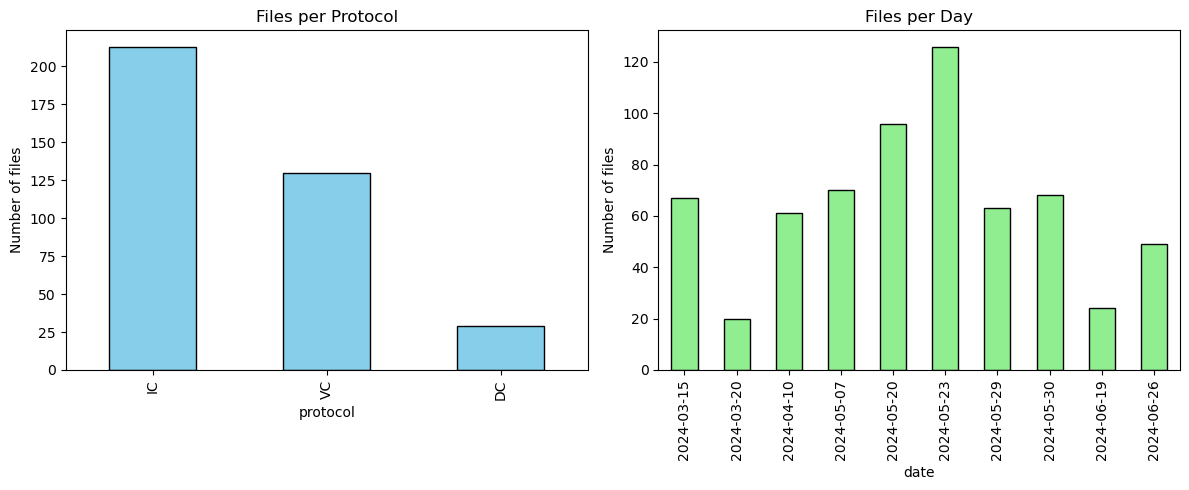

In [40]:
import matplotlib.pyplot as plt

# Create subplots: 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # adjust figsize as needed

# Files per protocol
protocol_counts = df['protocol'].value_counts()
protocol_counts.plot(
    kind='bar',
    color='skyblue',
    edgecolor='black',
    ax=axes[0],
    title='Files per Protocol'
)
axes[0].set_ylabel('Number of files')

# Files per day
day_counts = df['date'].value_counts().sort_index()
day_counts.plot(
    kind='bar',
    color='lightgreen',
    edgecolor='black',
    ax=axes[1],
    title='Files per Day'
)
axes[1].set_ylabel('Number of files')

plt.tight_layout()
plt.show()

## Filtering

### All dead cells experiments

In [41]:
# Filter rows where comments contain 'dead' (case-insensitive)
dead_cells = df[df['comments'].str.contains('dead', case=False, na=False)]

# Display the result
dead_cells

exp_nb cell_id        date protocol prot-opt    tp comments  \
66       67      C2  2024-03-15       IC     ramp  38.0     dead   
627     643     C26  2024-06-26       DC      NaN  25.0     dead   

                                        file_path  \
66   03.15/C2/2024_03_15_0066 IC ramp 38 dead.abf   
627       06.26/C2/2024_06_26_0032 25 DC dead.abf   

                               file_name  
66   2024_03_15_0066 IC ramp 38 dead.abf  
627       2024_06_26_0032 25 DC dead.abf

### All experiment of the day '2024-05-29'

In [42]:
# Filter rows for a specific day
day_data = df[df['date'] == '2024-05-29']

# Display the result
day_data

exp_nb cell_id        date protocol prot-opt    tp  comments  \
440     449     C18  2024-05-29       IC     ramp  25.0       NaN   
441     450     C18  2024-05-29       IC     ramp  28.0       NaN   
442     451     C18  2024-05-29       IC     ramp  31.0       NaN   
443     452     C18  2024-05-29       IC     ramp  34.0       NaN   
444     453     C18  2024-05-29       IC     ramp  37.0       NaN   
..      ...     ...         ...      ...      ...   ...       ...   
498     507     C19  2024-05-29      NaN      NaN  32.0       NaN   
499     508     C20  2024-05-29      NaN      NaN  33.0  immature   
500     509     C20  2024-05-29      NaN      NaN  34.0  immature   
501     510     C20  2024-05-29      NaN      NaN  35.0  immature   
502     511     C20  2024-05-29      NaN      NaN  36.0  immature   

                                 file_path                file_name  
440       05.29/C1/05.29 C1 IC ramp 25.atf  05.29 C1 IC ramp 25.atf  
441       05.29/C1/05.29 C1 IC ramp 28.atf  05.29 C1 IC ramp 28.atf  
442       05.29/C1/05.29 C1 IC ramp 31.atf  05.29 C1 IC ramp 31.atf  
443       05.29/C1/05.29 C1 IC ramp 34.atf  05.29 C1 IC ramp 34.atf  
444       05.29/C1/05.29 C1 IC ramp 37.atf  05.29 C1 IC ramp 37.atf  
..                                     ...                      ...  
498           05.29/C2/2024_05_29_0032.abf      2024_05_29_0032.abf  
499  05.29/C3 immature/2024_05_29_0033.abf      2024_05_29_0033.abf  
500  05.29/C3 immature/2024_05_29_0034.abf      2024_05_29_0034.abf  
501  05.29/C3 immature/2024_05_29_0035.abf      2024_05_29_0035.abf  
502  05.29/C3 immature/2024_05_29_0036.abf      2024_05_29_0036.abf  

[63 rows x 9 columns]

### All `IC ramp` 

In [43]:
# Filter rows with protocol 'IC' and protocol_option 'ramp'
ic_ramp_cells = df[(df['protocol'] == 'IC') & (df['prot-opt'] == 'ramp')]

# Display the result
ic_ramp_cells

exp_nb cell_id        date protocol prot-opt    tp comments  \
1         2      C1  2024-03-15       IC     ramp  23.0      NaN   
4         5      C1  2024-03-15       IC     ramp  25.0      NaN   
7         8      C1  2024-03-15       IC     ramp  27.0      NaN   
10       11      C1  2024-03-15       IC     ramp  29.0      NaN   
13       14      C1  2024-03-15       IC     ramp  31.0      NaN   
..      ...     ...         ...      ...      ...   ...      ...   
629     645     C27  2024-06-26       IC     ramp  25.0      NaN   
634     650     C27  2024-06-26       IC     ramp  28.0      NaN   
636     652     C27  2024-06-26       IC     ramp  31.0      NaN   
639     655     C27  2024-06-26       IC     ramp  34.0      NaN   
642     658     C27  2024-06-26       IC     ramp  37.0      NaN   

                                   file_path                       file_name  
1    03.15/C1/2024_03_15_0001 IC ramp 23.abf  2024_03_15_0001 IC ramp 23.abf  
4    03.15/C1/2024_03_15_0004 IC ramp 25.abf  2024_03_15_0004 IC ramp 25.abf  
7    03.15/C1/2024_03_15_0007 IC ramp 27.abf  2024_03_15_0007 IC ramp 27.abf  
10   03.15/C1/2024_03_15_0010 IC ramp 29.abf  2024_03_15_0010 IC ramp 29.abf  
13   03.15/C1/2024_03_15_0013 IC ramp 31.abf  2024_03_15_0013 IC ramp 31.abf  
..                                       ...                             ...  
629  06.26/C3/2024_06_26_0034 IC ramp 25.abf  2024_06_26_0034 IC ramp 25.abf  
634  06.26/C3/2024_06_26_0039 IC ramp 28.abf  2024_06_26_0039 IC ramp 28.abf  
636  06.26/C3/2024_06_26_0041 IC ramp 31.abf  2024_06_26_0041 IC ramp 31.abf  
639  06.26/C3/2024_06_26_0044 IC ramp 34.abf  2024_06_26_0044 IC ramp 34.abf  
642  06.26/C3/2024_06_26_0047 IC ramp 37.abf  2024_06_26_0047 IC ramp 37.abf  

[136 rows x 9 columns]

## `csvkit` the command-line Swiss Army knife
```{index} csvkit
```


OK, notebooks are great, but when navigating through data directories, you may come across a CSV file—or, if you’re less lucky, an Excel file. Don’t panic: there’s a handy tool for that: [csvkit](https://csvkit.readthedocs.io/en/latest/), it is a (nice) suite of command-line tools for converting to and working with CSV, the king of tabular file formats. See Section "{ref}`section-csvkit`" and/or the [tutorial](https://csvkit.readthedocs.io/en/latest/tutorial.html).



Look at column names:

In [45]:
!csvcut -n  data/data_bcam_2024/records_metadata_clean.csv 

  1: exp_nb
  2: cell_id
  3: date
  4: protocol
  5: prot-opt
  6: tp
  7: comments
  8: file_path
  9: file_name


Pretty print of the (head of) columns 2,3,8:

In [46]:
!csvcut -c 2,3,8 data/data_bcam_2024/records_metadata_clean.csv | csvlook | head

| cell_id |       date | file_path                                       |
| ------- | ---------- | ----------------------------------------------- |
| C1      | 2024-03-15 | 03.15/C1/2024_03_15_0000 IC steps 23.abf        |
| C1      | 2024-03-15 | 03.15/C1/2024_03_15_0001 IC ramp 23.abf         |
| C1      | 2024-03-15 | 03.15/C1/2024_03_15_0002 IC sin 23.abf          |
| C1      | 2024-03-15 | 03.15/C1/2024_03_15_0003 VC ramp 23.abf         |
| C1      | 2024-03-15 | 03.15/C1/2024_03_15_0004 IC ramp 25.abf         |
| C1      | 2024-03-15 | 03.15/C1/2024_03_15_0005 IC sin 25.abf          |
| C1      | 2024-03-15 | 03.15/C1/2024_03_15_0006 VC ramp 25.abf         |
| C1      | 2024-03-15 | 03.15/C1/2024_03_15_0007 IC ramp 27.abf         |


Stats on "date" and "tp:

In [47]:
!csvcut -c date,tp data/data_bcam_2024/records_metadata_clean.csv | csvstat

  1. "date"

	Type of data:          Date
	Contains null values:  False
	Non-null values:       644
	Unique values:         10
	Smallest value:        2024-03-15
	Largest value:         2024-06-26
	Most common values:    2024-05-23 (126x)
	                       2024-05-20 (96x)
	                       2024-05-07 (70x)
	                       2024-05-30 (68x)
	                       2024-03-15 (67x)

  2. "tp"

	Type of data:          Number
	Contains null values:  True (excluded from calculations)
	Non-null values:       635
	Unique values:         73
	Smallest value:        0,
	Largest value:         69,
	Sum:                   18044,5
	Mean:                  28,417
	Median:                28,
	StDev:                 12,181
	Most decimal places:   1
	Most common values:    25, (96x)
	                       34, (66x)
	                       31, (50x)
	                       28, (45x)
	                       40, (33x)

Row count: 644


Show a nice table of all files where "prot-opt" is steps, including only the "cell_id", "protocol", "prot-opt", and "file_name" columns:

In [48]:
!csvcut -c cell_id,protocol,prot-opt,file_name data/data_bcam_2024/records_metadata_clean.csv | csvgrep -c prot-opt -m steps | csvlook

| cell_id | protocol | prot-opt | file_name                              |
| ------- | -------- | -------- | -------------------------------------- |
| C1      | IC       | steps    | 2024_03_15_0000 IC steps 23.abf        |
| C1      | IC       | steps    | 2024_03_15_0018 IC steps 34.abf        |
| C2      | IC       | steps    | 2024_03_15_0036 IC steps 23.abf        |
| C3      | IC       | steps    | 2024_03_20_0007 IC square steps 38.abf |
| C23     | IC       | steps    | 2024_06_19_0000 IC steps 25.abf        |
| C23     | IC       | steps    | 2024_06_19_0009 IC steps 34.abf        |
| C24     | IC       | steps    | 2024_06_19_0014 IC steps 25.abf        |
| C25     | IC       | steps    | 2024_06_26_0000 IC steps 25.abf        |
| C25     | IC       | steps    | 2024_06_26_0016 IC steps 34.abf        |
| C25     | IC       | steps    | 2024_06_26_0022 IC steps 40.abf        |
| C26     | IC       | steps    | 2024_06_26_0028 IC steps 25.abf        |
| C27     | IC       | st

You can pipe all the line commands. For example, get cell_id and file_name for all IC steps:

In [49]:
!bash -c "csvgrep -c protocol -m IC data/data_bcam_2024/records_metadata_clean.csv \
| csvgrep -c prot-opt -m steps \
| csvcut -c cell_id,file_name \
| csvlook"

| cell_id | file_name                              |
| ------- | -------------------------------------- |
| C1      | 2024_03_15_0000 IC steps 23.abf        |
| C1      | 2024_03_15_0018 IC steps 34.abf        |
| C2      | 2024_03_15_0036 IC steps 23.abf        |
| C3      | 2024_03_20_0007 IC square steps 38.abf |
| C23     | 2024_06_19_0000 IC steps 25.abf        |
| C23     | 2024_06_19_0009 IC steps 34.abf        |
| C24     | 2024_06_19_0014 IC steps 25.abf        |
| C25     | 2024_06_26_0000 IC steps 25.abf        |
| C25     | 2024_06_26_0016 IC steps 34.abf        |
| C25     | 2024_06_26_0022 IC steps 40.abf        |
| C26     | 2024_06_26_0028 IC steps 25.abf        |
| C27     | 2024_06_26_0033 IC steps 25.abf        |
| C27     | 2024_06_26_0043 IC steps 34.abf        |


(`bash -c` is a way to tell Bash to execute a command string as if you typed it directly in a terminal)